In [1]:
import torch
from torch import nn
from d2l import torch as d2l

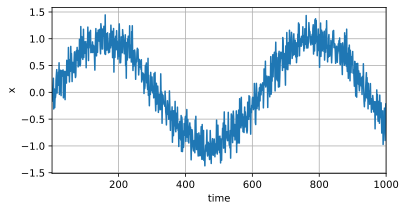

In [2]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.randn(T) * 0.2

d2l.plot(time, x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)


def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net


loss = nn.MSELoss()

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epochs in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epochs + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss)}')


net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.06742370545275901
epoch 2, loss: 0.05604509955370113
epoch 3, loss: 0.05281919211541351
epoch 4, loss: 0.05338218254282286
epoch 5, loss: 0.05477610926486944


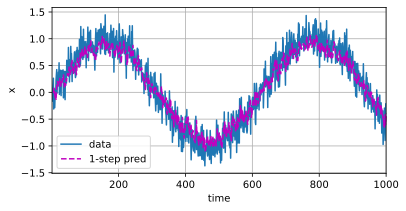

In [6]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step pred'], xlim=[1, 1000], figsize=(6, 3)
)

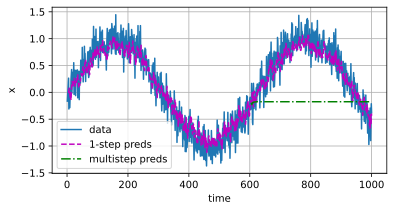

In [7]:
multistep_preds = torch.zeros(T)
multistep_preds[:] = x
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(),
          onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:]],
         'time', 'x',
         legend=['data', '1-step preds', 'multistep preds'],
         figsize=(6, 3))

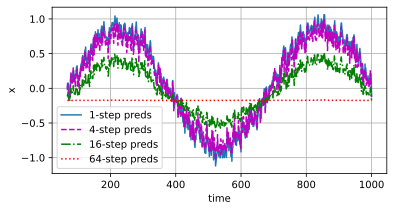

In [8]:
def k_step_pred(k):
    features = []
    for i in range(tau):
        features.append(x[i: i + T - tau - k + 1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = net(torch.stack(features[i: i + tau], 1))
        features.append(preds.reshape(-1))
    return features[tau:]


steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(time[tau + steps[-1] - 1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))